DRW-Based Outlier Rejection
==========================

What is a Damped Random Walk?
-----------------------------

The first step of the pyPetal pipeline is to perform outlier rejection on the input light curve data. This can be done by assuming a certain model for the light curves, fitting them to said model, and rejecting points a certain number of $\sigma$ away from the mean fit.

.. note:: We follow the description of the DRW parameters (and CARMA models in general) from <cite data-cite="brockwell_continuous-time_2001">Brockwell et al. (2001)</cite> and <cite data-cite="kelly_flexible_2014">Kelly et al. (2014)</cite>.

One of the popular models used for AGN light curve data is the Damped Random Walk (DRW) model. This Gaussian process model has a kernel of the following form:

$k(t_n, t_m) = \sigma_{\rm DRW}^2 \exp\left( |t_n - t_m| / \tau_{\rm DRW}  \right)$

with the two DRW parameters: $\sigma_{\rm DRW}$ and $\tau_{\rm DRW}$.

We can also add a noise (jitter) term to the kernel to account for additional noise:

$k(t_n, t_m) = \sigma_{\rm DRW}^2 \exp\left( |t_n - t_m| / \tau_{\rm DRW}  \right) + \sigma_n^2$


This produces a power spectral density (PSD) of the following form:

$P(f) = \frac{4 \sigma_{\rm DRW}^2 \tau_{\rm DRW}}{1 + (2\pi f \tau_{\rm DRW})^2}$

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

tau = 250
sigma = .2
freqs = np.logspace(-5, 0, 1000)

psd = 4*(sigma**2)*tau / ( 1 + (2*np.pi*freqs*tau)**2 )


fig, ax = plt.subplots()

ax.loglog(freqs, psd, zorder=100)
ax.axvline( 1/tau/2/np.pi, color='gray', ls='--')
ax.axhline( 4*(sigma**2)*tau, color='gray', ls='--')

ax.text( 2, 4*(sigma**2)*tau, r'$4 \sigma_{\rm DRW}^2\tau_{\rm DRW}$', fontsize=13, va='center' )
ax.text( 1/tau/2/np.pi, 120, r'$(2 \pi \tau_{\rm DRW})^{-1}$', fontsize=13, ha='center')

ax.set_ylabel('Power', fontsize=16)
ax.set_xlabel('Frequency', fontsize=16)
plt.show()

From this, we can see that $\tau_{\rm DRW}$ is a characteristic damping timescale, and $\sigma_{\rm DRW}$ is related to the magnitude of long-term variability.

We can fit a given light curve to the DRW model using two important softwares: the fast Gaussian process solver `celerite` <cite data-cite="foreman-mackey_fast_2017">(Foreman-Mackey et al. 2017)</cite>, and the MCMC sampler `emcee` <cite data-cite="foreman-macky_emcee_2013">(Foreman-Mackey et al. 2013)</cite>.

These can find the posterior distributions for the two (or three) DRW parameters, predict the light curve at an arbitrary (and likely higher) cadence, and sample the posterior using MCMC. 

DRW Rejection Arguments
------------------------------

As shown in the quick-start tutorial, we can use the DRW rejection module by simply setting ``run_drw_rej=True``. However, this uses the default values for the parameters for the module, which may need to be changed to fit the needs of a given type of analysis.

There are a anumber of arguments that we discuss here, but can also be found in the API documnentation:

<ins>__MCMC options__</ins>

* ``nwalkers``: The number of walkers to use in the MCMC sampler. The default is 32.
* ``nburn``: The number of burn-in steps to use in the MCMC sampler. The default is 300.
* ``nchain``: The number of steps to use in the MCMC sampler. The default is 1000.




<ins>__DRW options__</ins>

* ``jitter``: If the jitter term should be included in the DRW model. The default is ``True``.
* ``clip``: If ``True``, the lower bound on the prior will be the mean cadence of the light curve without cadences $< 10^{-8}$. This can be specified as a list of values corresponding to each light curve. If one value is given, it will be assumed for all light curves. The default is ``True``. 


<ins>__Rejection options__</ins>

* ``nsig``: The number of $\sigma$ away from the mean fit to reject points. The default is 1.
* ``reject_data``: If the data should be rejected, and the outliers should not be used for the rest of the pipeline. Similar to ``clip``, this is specified as an array, one for each light curve, or one value for all light curves. The default is ``False``.

.. note:: If ``reject_data=True`` for a given light curve, a new file will be saved in ``output_dir`` without the outlier points included.

.. warning:: If ``reject_data=False`` for a given light curve, it will not be fit to a DRW, and no diagnostic information will be produced.




<ins>__Miscellaneous options__</ins>

* ``use_for_javelin`` : If the fit to the DRW parameters ($\sigma_{\rm DRW}, \tau_{\rm DRW}$) should be used as fixed input parameters for the JAVELIN module. Default is ``False``.

.. note:: Only the fit to the continuum (first) light curve will be used as input to the JAVELIN module.

An Example Output Plot
----------------------

Each light curve will produce a DRW fit, and a corresponding figure. Each figure will have three different subplots within it:

#. The top panel will have the original plot and the DRW fit shown in orange. The mean of the fit will be in darker orange, and the $1\sigma$ uncertainty will be shaded above and below the mean in a lighter orange. Rejected points will be shown as a light gray, while other points will be black.

#. The lower left will have a corner plot, showing contours of the MCMC samples of the posteriors for the DRW parameters. The histograms and contours will be shaded red where the $\tau_{\rm DRW}$ is greater than 10% of the baseline (total length) of the light curve.

#. The lower right will be a figure containing the PSD of the data from a variety of different methods: 

    * The light orange-shaded PSD is from the ``celerite`` DRW fit, which represents the 16-84% of the PSD. 
    * The light-blue line represents the data-based PSD, which is the Lomb-Scargle periodogram. 
    * This data-based PSD is then binned logarithmically in frequency to give the black lines and uncertainties.
    * This binned PSD will then be fit to a doubly-broken power law, shown as a red line. 
    * Like the corner plot, the figure is shaded red where $1/f$ is greater than 10% of the baseline, but also where $f$ is less than the minimum cadence between data points in the light curve.
    * There will be a red arrow pointing to the median $\tau_{\rm DRW}$ from the fit, and a horizontal red line underneath it showing the $\pm 1\sigma$ uncertainty.

Using the Module
----------------

Now that we know the arguments, we can run the DRW rejection module in a more customized way.

We can input the custom parameters in a dictionary, with the ``drw_rej_params`` argument:

In [1]:
import pypetal.pipeline as pl

main_dir = '../../examples/dat/javelin_'
filenames = [ main_dir + 'continuum.dat', main_dir + 'yelm.dat', main_dir + 'zing.dat' ]

output_dir = '../../examples/drw_rej_ouput/'
line_names = ['Continuum', 'H-alpha', 'H-beta']


Performing DRW rejection
------------------------
jitter: False
nsig: 0.5
nwalker: 100
nburn: 50
nchain: 100
clip: array
reject_data: [True, False, True]
use_for_javelin: False
------------------------
        


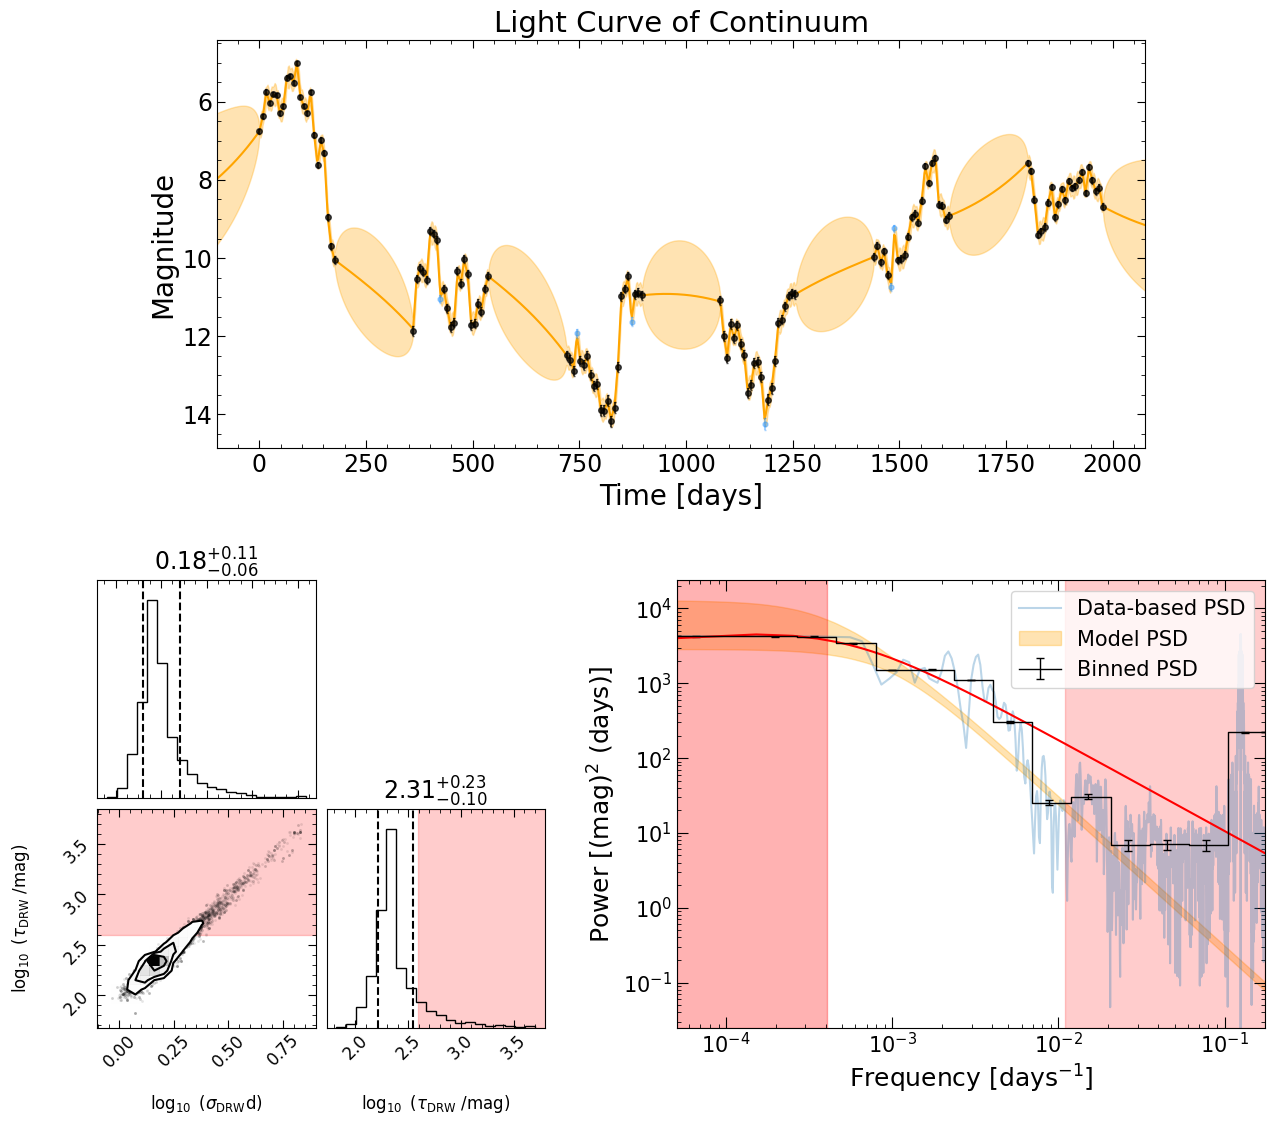

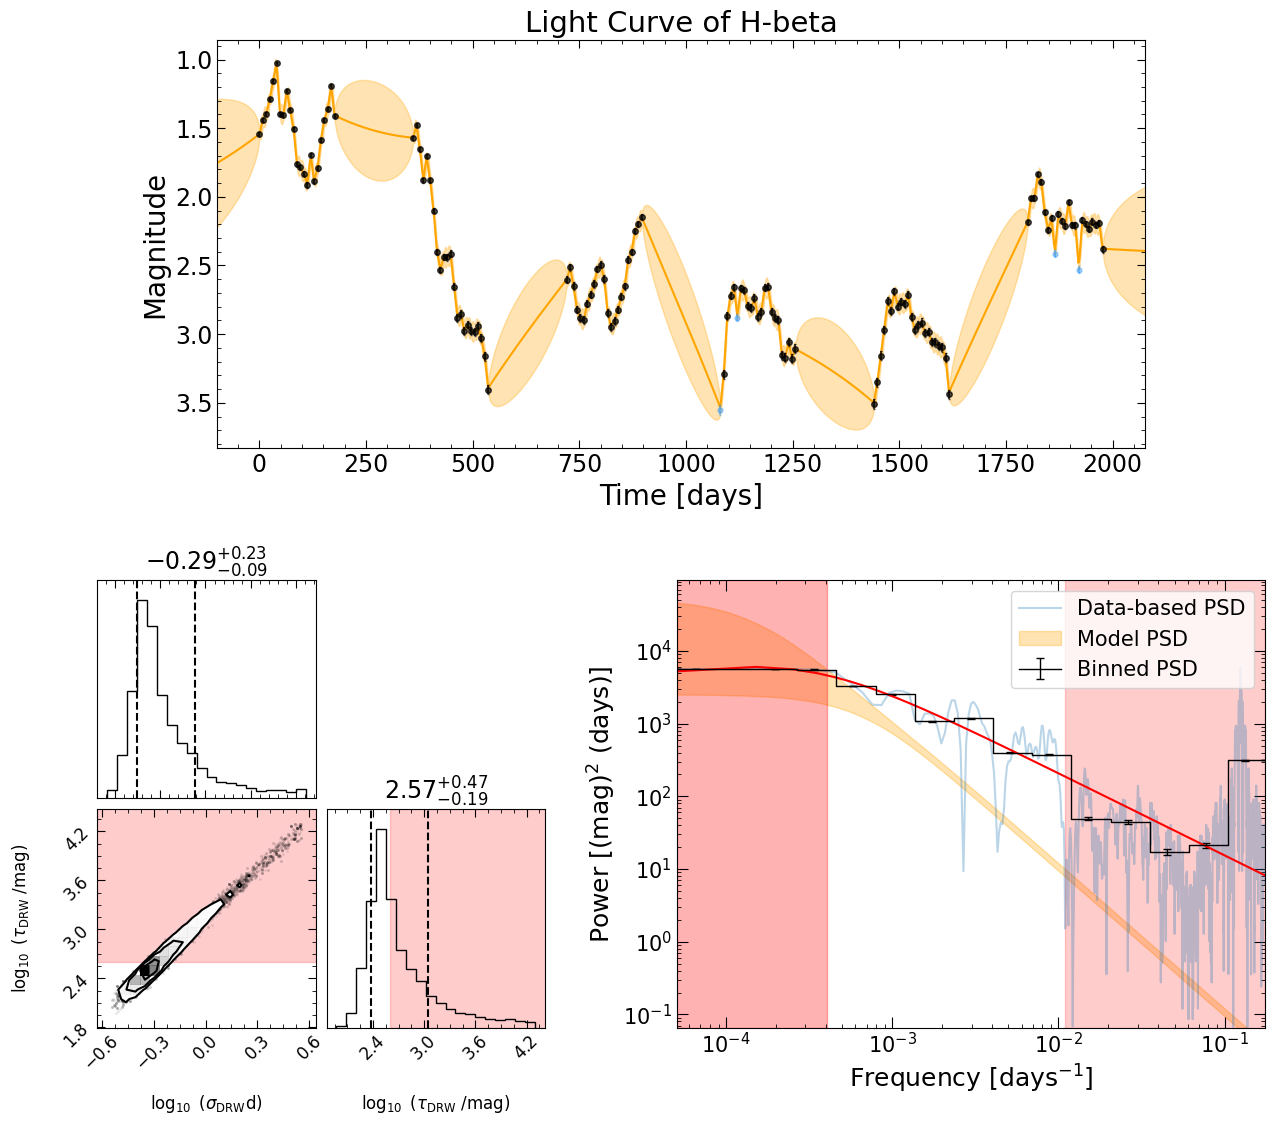

In [2]:
params = {
    'nwalker': 10,
    'nburn': 50,
    'nchain': 100,
    'jitter': False,
    'nsig': 0.5,
    'reject_data': [True, False, True]
}

res = pl.run_pipeline( output_dir, filenames, line_names,
                       run_drw_rej=True, 
                       drw_rej_params=params,
                       verbose=True,
                       plot=True,
                       file_fmt='ascii',
                       time_unit='d',
                       lc_unit='mag')

DRW Rejection Output Files
---------------------------

The DRW Rejection can have a number of outputs, which depends on the number of light curves input to the pipeline. Each light curve's directory will have a subdirectory labeled "drw_rej", which will contain all output information.

This subdirectory will contain the following files, where (name) is the name of the light curve:

* ``(name)_chain.dat``: The MCMC chains for the DRW parameters.
* ``(name)_drw_fit.dat``: The predicted light curve from the DRW fit, containing the times, mean fit, and $1\sigma$ fit uncertainty.
* ``(name)_mask.dat``: The mask for the DRW rejection, where ``True`` corresponds to a point being rejected.
* ``(name)_drw_fit.pdf``: The output summary figure for the DRW fit.

In the ``light_curves`` subdirectory, each light curve file will have a fourth column, which is the mask for the DRW rejection. This will be ``True`` for points that are rejected, and ``False`` for points that are not rejected.

If ``reject_data=True`` for any light curve, there will also be a ``rejected_lcs`` subdirectory, containing the light curves without rejected points. The light curves with ``reject_data=False`` will also be saved, but with all points. These light curves will be used for the rest of the pipeline. 

If ``reject_data=False`` for a given light curve, the DRW fit will not be performed, and no output files will be produced.

DRW Rejection Output Dict
-------------------------

The DRW Rejection module will output a number of different data products from the analysis it has performed in a ``dict``. This will be stored in the total output ``dict`` under the key ``drw_rej_res``. 


This output ``dict`` will contain the following keys:

* ``masks``: A list of the DRW rejection masks, one for each light curve.

* ``reject_data``: A copy of the ``reject_data`` argument.

* ``taus``: A list of the MCMC samples for $\tau_{\rm DRW}$.

* ``sigmas``: A list of the MCMC samples for $\sigma_{\rm DRW}$.

* ``jitters``: A list of the MCMC samples for the jitter term. If ``jitter=False``, this will be ``None``.

.. note:: The ``taus``, ``sigmas``, and ``jitters`` will be lists of MCMC samples for each light curve. If ``reject_data=False`` for a given light curve, the entry in that list will be ``None``.

.. bibliography::